In [27]:
#Code from Fabio to import index data including applying comp matrix - JT mods added, AS mods added
import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import fcsparser

In [28]:
#Functions defined here

#Extract indexed data

def get_inx(meta : dict):
    i = 1
    key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = [] #Sort locations from the metadata, numerical row then column starting at 0
    while key in meta:
        sort_locs.append(meta[key])
        i += 1
        key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = ''.join(sort_locs).split(';')
    return sort_locs

#Plot data per plate - works before assigning cell type

def CD34flowplot_byplate(sourcedata, gates, data_name):
#Function for plotting processed flow data by sourceplate (4 plates designated here)
#Currently set to colour 4th plate red (sorted for CD38 negative), can change # in col variable to swap to random colours
#3 inputs, sourcedata, gates, data_name
#sourcedata is the df containing the fcs data, possibly pre-compensated
#gates is the location of each gating line
#data_name is the name to be applied to legends and output files

    #Here's what's being plotted

    plot_list = [
        ['FSC-A', 'SSC-A'],
        ['FSC-A', 'FSC-W'],
        ['SSC-A', 'SSC-H'],
        ['Zombie', 'Lin-PE-Cy5'], 
        ['CD34-PE', 'CD38-APC-cy7'],
        ['IL1RAP-APC', 'CD38-APC-cy7'],
        ['CD45RA-FITC', 'CD123-PE-Cy7'],
        ['CD45RA-FITC', 'CD90-BV421']
    ]


    #Define colour palette here, and make a new column for it 
    plates = sourcedata['Plate'].drop_duplicates().to_list()
    cols = ['gray', 'green', 'green', 'red'] #can replace the colours used here
    #cols = sns.color_palette('husl', n_colors = len(plates))
    palette = dict(zip(plates, cols))

    sourcedata['Colour'] = sourcedata['Plate'].map(palette)

    #Which fluorophores are on a log scale
    logs = ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7','Zombie', 'IL1RAP-APC', 'CD90-BV421' ]

    fig, axs = plt.subplots(4,2, figsize = (13,24))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    for ax,y in zip(axs, plot_list):
        x_label = y[0]
        y_label = y[1]
        ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.3, c = sourcedata['Colour'], s = 5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
       #ax.legend()
        if x_label in logs:
            ax.set_xscale('log')
            ax.set_xlim(left = 10)
        if y_label in logs:
            ax.set_yscale('log')
            ax.set_ylim(bottom = 10)
        if x_label in gates:
            ax.axvline(gates[x_label], ls = '--', c = 'k')
        if y_label in gates:
            ax.axhline(gates[y_label], ls = '--', c = 'k')   
        
        ax.autoscale_view()  

    fig.suptitle(f'{data_name}', fontsize=16) 

    fig.savefig(f'../Results/Indexing/{data_name}_plot_by_plate.png',dpi=300) 
    
#Assign cell type using defined gates

def celltype_assign(data_in, gates_in, data_name):
#Takes 3 inputs, source df, gates dictionary, string containing name for data output
#Assume sort gates actually dumped dead, lin pos cells

    #Create boolean matrix based on gates in new columns

    data_in['CD34_pos'] = data_in['CD34-PE'] >= gates_in['CD34-PE']
    data_in['CD38_pos'] = data_in['CD38-APC-cy7'] >= gates_in['CD38-APC-cy7']
    data_in['CD38_neg'] = data_in['CD38-APC-cy7'] < gates_in['CD38-APC-cy7']
    data_in['IL1RAP_pos'] = data_in['IL1RAP-APC'] >= gates_in['IL1RAP-APC']
    data_in['IL1RAP_neg'] = data_in['IL1RAP-APC'] < gates_in['IL1RAP-APC']
    data_in['CD45RA_pos'] = data_in['CD45RA-FITC'] >= gates_in['CD45RA-FITC']
    data_in['CD45RA_neg'] = data_in['CD45RA-FITC'] < gates_in['CD45RA-FITC']
    data_in['CD123_pos'] = data_in['CD123-PE-Cy7'] >= gates_in['CD123-PE-Cy7']
    data_in['CD123_neg'] = data_in['CD123-PE-Cy7'] < gates_in['CD123-PE-Cy7']
    data_in['CD90_pos'] = data_in['CD90-BV421'] >= gates_in['CD90-BV421']
    data_in['CD90_neg'] = data_in['CD90-BV421'] < gates_in['CD90-BV421']


    #Define each cell type - doing this explicitly to make code easier to follow. Tweaked to include IL1RAP neg for normal 38- cells

    lsc = ['CD34_pos','CD38_neg','IL1RAP_pos']
    hsc = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD90_pos']
    mpp = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD90_neg']
    lmpp = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_pos']
    cmp = ['CD34_pos','CD38_pos','CD45RA_neg','CD123_pos']
    gmp = ['CD34_pos','CD38_pos','CD45RA_pos','CD123_pos']
    gmp2 = ['CD34_pos','CD38_pos','CD45RA_pos','CD123_neg'] #are these the unassigned cells? Looks like it
    mep = ['CD34_pos','CD38_pos','CD45RA_neg','CD123_neg']


    markers = [
        'CD34_pos' ,
        'CD38_pos' ,
        'CD38_neg' ,
        'IL1RAP_pos' ,
        'CD45RA_pos' ,
        'CD45RA_neg' ,
        'CD123_pos' ,
        'CD123_neg' ,
        'CD90_pos' ,
        'CD90_neg'
    ]

    col_names = ['lsc', 'hsc', 'mpp', 'lmpp', 'cmp', 'gmp', 'gmp2','mep']
    celltypes = ['LSC', 'HSC', 'MPP', 'LMPP', 'CMP', 'GMP', 'GMP2', 'MEP']
    alltypes = [lsc, hsc, mpp, lmpp, cmp, gmp, gmp2, mep]

    #Store list of which columns are true for each cell type in a dictionary

    criteria = dict(zip(col_names, alltypes))


    #Use calculated criteria to add cell type true/false columns

    for x in col_names:
        data_in[x] = (data_in[criteria[x]] == True).all(axis = 1)

    data_in['unassigned'] = (data_in[col_names] == False).all(axis = 1)

    #Create a new column that contains the cell type

    col_names.append('unassigned')  #account for cells that were not assigned
    celltypes.append('unassigned')

    for a, b in zip(col_names, celltypes):

        data_in.loc[data_in[a] == True, 'celltype'] = b 

    #Define colour palette here, and make a new column for it

    ct = data_in['celltype'].drop_duplicates().to_list()
    col = sns.color_palette('husl', n_colors = len(ct))
    palette = dict(zip(ct, col))
    data_in['Colour'] = data_in['celltype'].map(palette)

    #Create a file containing assigned cell type for each well

    data_in.to_csv(f'../Data/{data_name}_index.tsv', sep = '\t')    #Save the big df to a file
    wellID = data_in[['Plate_Well', 'celltype']]
    wellID.to_csv(f'../Data/{data_name}_index_ID.tsv', sep = '\t')    #Save the well assignment to a file


    #Make a plot of cell type distributions

    fig, ax = plt.subplots()

    c = data_in['celltype'].value_counts().rename_axis('cell').reset_index(name='counts')
    ax = sns.barplot(x='cell', y='counts', data = c, palette = palette)

    fig.suptitle(f'{data_name}', fontsize=16)
    fig.savefig(f'../Results/Indexing/{data_name}_celltype_dist.png',dpi=300) 
    
    return data_in
    
    #TODO!!!! Need to return the dataframe
    
#Plot data coloured by cell type
#Needs processed data that has the assigned 'celltype' column. FAILS until fixing df return from above.

def CD34flowplot_bycelltype(sourcedata, gates, data_name):
#3 inputs, sourcedata, gates, data_name
#sourcedata is the df containing the fcs data, possibly pre-compensated
#gates is the location of each gating line
#data_name is the name to be applied to legends and output files

    #Here's what's being plotted

    plot_list = [
        ['FSC-A', 'SSC-A'],
        ['FSC-A', 'FSC-W'],
        ['SSC-A', 'SSC-H'],
        ['Zombie', 'Lin-PE-Cy5'], 
        ['CD34-PE', 'CD38-APC-cy7'],
        ['IL1RAP-APC', 'CD38-APC-cy7'],
        ['CD45RA-FITC', 'CD123-PE-Cy7'],
        ['CD45RA-FITC', 'CD90-BV421']
    ]


    #Define colour palette here, and make a new column for it 

    ct = sourcedata['celltype'].drop_duplicates().to_list()
    col = sns.color_palette('husl', n_colors = len(ct))
    palette2 = dict(zip(ct, col))

    sourcedata['Colour'] = sourcedata['celltype'].map(palette2)


    #Which fluorophores are on a log scale
    logs = ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7','Zombie', 'IL1RAP-APC', 'CD90-BV421' ]

    fig, axs = plt.subplots(4,2, figsize = (13,24))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    for ax,y in zip(axs, plot_list):
        x_label = y[0]
        y_label = y[1]
        ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.3, c = sourcedata['Colour'], s = 5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
       #ax.legend()
        if x_label in logs:
            ax.set_xscale('log')
            ax.set_xlim(left = 10)
        if y_label in logs:
            ax.set_yscale('log')
            ax.set_ylim(bottom = 10)
        if x_label in gates:
            ax.axvline(gates[x_label], ls = '--', c = 'k')
        if y_label in gates:
            ax.axhline(gates[y_label], ls = '--', c = 'k')   
        
        ax.autoscale_view()  

    fig.suptitle(f'{data_name}', fontsize=16)    
    fig.savefig(f'../Results/Indexing/{data_name}_plot_by_celltype.png',dpi=300) 

In [29]:
#Plate QC - check that cells are in the expected locations

directory = '../Data/RN_BM/Indexed/'

#Count the number of plates
count = 0
for filename in os.listdir(directory):
    count += 1
    
plotlen = int(math.ceil(count/2))

#Set up the plots
fig, ax = plt.subplots(plotlen,2, figsize = (16,plotlen*5))
ax = ax.ravel()
fig.subplots_adjust(hspace = 0.3, wspace=.3)

count = -1

xwell = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
ywell = [0,1,2,3,4,5,6,7,8,9,0,11,12,13,14,15]
allwells = []

for a in ywell: #this creates a list of all possible locations
    for b in xwell:
        allwells.append(str(a) + ','+ str(b))
        
#Read in files and plot the data for each

for filename in os.listdir(directory):
    fn = os.path.join(directory, filename)
    plateid = (fn.split('/'))[4]
    
    count += 1

    meta, data = fcsparser.parse(fn, reformat_meta=True)

    sort_locs = get_inx(meta)

    for well in allwells:
        if well in sort_locs:  #if the well is in the list of wells with a sorted cell the colour will be darker
            alpha = 0.8
        else:
            alpha = 0.1        #plot empty wells in a lighter shade
            
        y, x = well.split(',')
        ax[count].scatter(x, y, alpha=alpha, color='gray')      
    ax[count].set_title(plateid)
    ax[count].invert_yaxis()  #flip the axis so the plate order looks natural
    ax[count].set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24'])
    ax[count].set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'])

fig.suptitle('CD34 plates', fontsize=14)    
fig.savefig(f'../Results/Indexing/CD34_plate.png',dpi=300)           
plt.close()

In [30]:
#Now read data into df and apply compensation, then output combined df with all rw or comp values
directory = '../Data/RN_BM/Indexed/'

data_dict = {}
data_dict_comp = {}

plate_key = {'Sample_INX_AS0055-CD34_001_012.fcs': 'not_seq',
 'Sample_INX_AS0055-CD34_002_013.fcs': 'AS-197',
 'Sample_INX_AS0055-CD34_003_014.fcs': 'AS-198',
 'Sample_INX_AS0055-CD34_004_015.fcs': 'AS-201'}

#Set up comp plots
fig, ax = plt.subplots(2,2, figsize = (8,6))
ax = ax.ravel()
fig.subplots_adjust(hspace = 0.3, wspace=.3)

count = -1

#Read in files and metadata

for filename in os.listdir(directory):
    fn = os.path.join(directory, filename)
    plateid = (fn.split('/'))[4]
    count += 1

    meta, data = fcsparser.parse(fn, reformat_meta=True)
    
    sort_locs = get_inx(meta)

    wells = []
    for loc in sort_locs:
        if loc == '':
            continue
        row_index, col = loc.split(',')
        col = str(int(col)+1)
        row = chr(65 + int(row_index)) 
        well = row+col
        wells.append(well)   #Wells is a list of well locations with data derived from the index file
    
    # Get antibodies and rename with well names
    channel_idx = [int(x[2:-1]) for x in meta if x.startswith('$P') and x.endswith('S')]
    channeld = {meta['_channel_names_'][i-1]: meta[f'$P{i}S'] for i in channel_idx}

    data.index = pd.Index(wells, name='Sorted well') #Renames index with well name
    
    # Load compensation
    comp_fields = meta['SPILL'].split(',')
    n = int(comp_fields[0])
    channels = comp_fields[1: n+1]
    matrix = np.asarray(comp_fields[n+1:]).astype(np.float64).reshape((n, n)) 
 
    matrix = numpy.linalg.inv(matrix)
    
    spill_matrix = pd.DataFrame(
        matrix,
        index=channels,
        columns=channels,
    )  #spill_matrix is the comp matrix
    
    #Plots compensation matrix
    # Reorder the dyes by wavelength
    wls = [int(x.split('/')[0][-3:]) for x in channels]
    idx = np.argsort(wls)
    spill_by_wls = spill_matrix.iloc[idx].T.iloc[idx].T

    ax[count] = sns.heatmap(spill_by_wls, ax=ax[count])
    ax[count].set_title(plateid)

    
    #Apply comp and replace column names with antibodies
    data_comp = data.copy()
    compensation = spill_matrix
    
    for channel in channels:
        data_comp[channel] = compensation.loc[:,channel].values @ data[channels].values.T #@ for matrix multiplication
    
    #Store df and compdf for this iteration as a unique variable
    data_comp.rename(columns = channeld, inplace = True)
    data.rename(columns = channeld, inplace = True)
    
    plate = plate_key.get(filename) #pull the plate name for this file and use to label output dictionaries
    data['Well'] = data.index.get_level_values(0)
    data_comp['Well'] = data_comp.index.get_level_values(0)
    data['Plate'] = plate #add new column with plate name
    data_comp['Plate'] = plate  #add new column with plate name
    data_dict_comp[plate] = data_comp #output df into a dictionary
    data_dict[plate] = data  #output df into a dictionary      
  
fig.tight_layout()  
plt.close() #comment out to view comp plots

#Combine all data or data_comp df into a single large df for gating
CD34_alldata = data_dict['not_seq'].append(data_dict['AS-197'], ignore_index=True).append(data_dict['AS-198'], ignore_index=True).append(data_dict['AS-201'], ignore_index=True)
CD34_alldata_comp = data_dict_comp['not_seq'].append(data_dict_comp['AS-197'], ignore_index=True).append(data_dict_comp['AS-198'], ignore_index=True).append(data_dict_comp['AS-201'], ignore_index=True)

#Add column to combine plate and well
CD34_alldata['Plate_Well'] = CD34_alldata['Plate'].astype(str) + '_' + CD34_alldata['Well'].astype(str)
CD34_alldata_comp['Plate_Well'] = CD34_alldata_comp['Plate'].astype(str) + '_' + CD34_alldata_comp['Well'].astype(str)

In [40]:
#Next step is to set gates for each fluorophore. These are adjusted in this cell for now
#Raw data
gate_loc = {
    'Lin-PE-Cy5': 2000,
    'CD34-PE': 280 ,
    'CD38-APC-cy7': 3000 ,
    'CD45RA-FITC': 1000 ,
    'CD123-PE-Cy7': 400,
    'Zombie': 8000,
    'IL1RAP-APC': 800,
    'CD90-BV421': 500,
}

#Compensated data
gate_loc_comp = {
    'Lin-PE-Cy5': 1000,
    'CD34-PE': 280 ,
    'CD38-APC-cy7': 2500 ,
    'CD45RA-FITC': 1000 ,
    'CD123-PE-Cy7': 200,
    'Zombie': 8000,
    'IL1RAP-APC': 300,
    'CD90-BV421': 500,
}

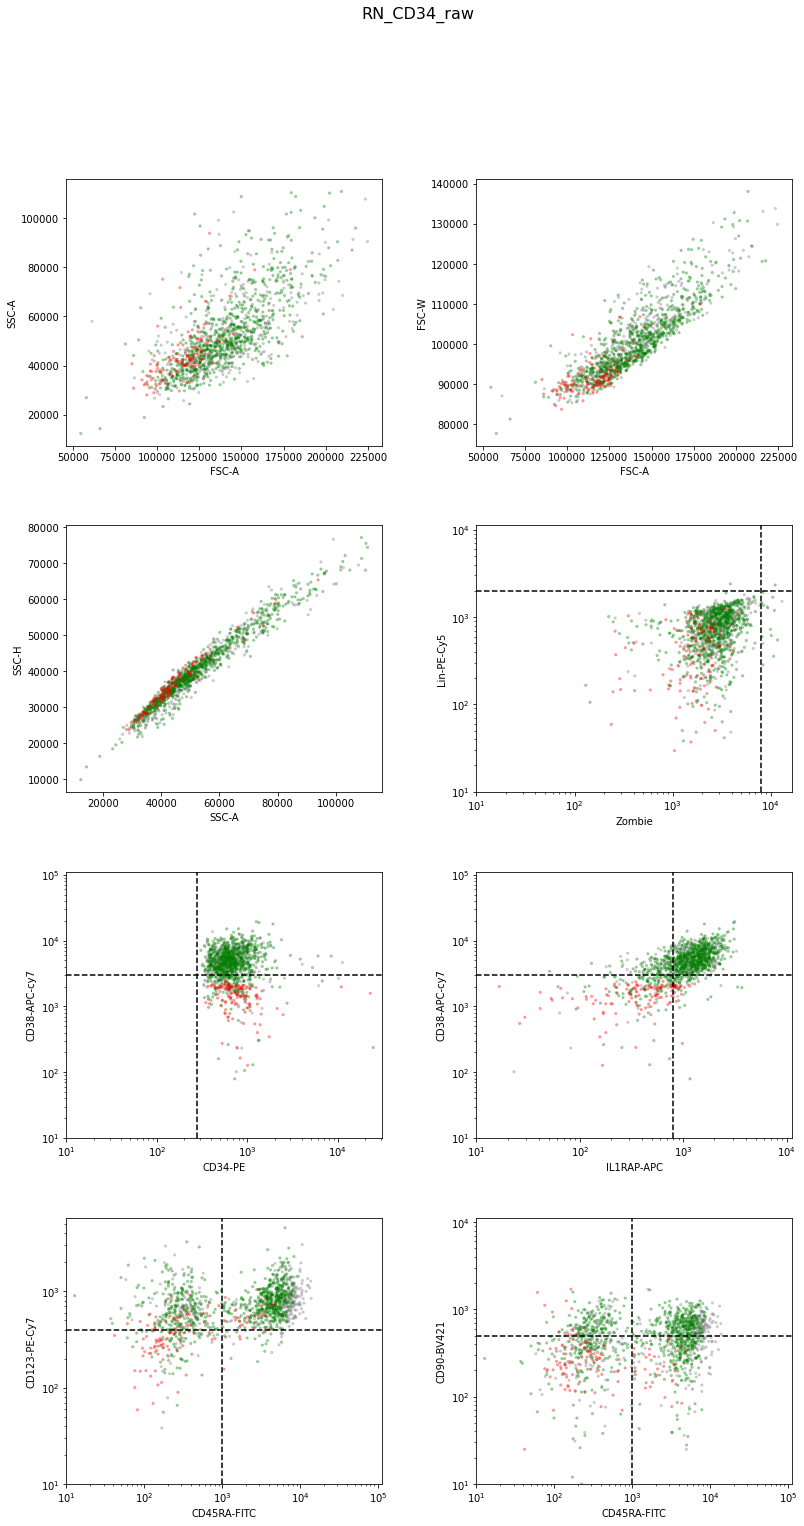

In [41]:
#Plot with colour by origin plate. Red cells were sorted CD38neg, grey cells are the bulk plate with no amplicon seq

CD34flowplot_byplate(CD34_alldata, gate_loc, 'RN_CD34_raw')
#CD34flowplot_byplate(CD34_alldata_comp, gate_loc_comp, 'RN_CD34_comp')

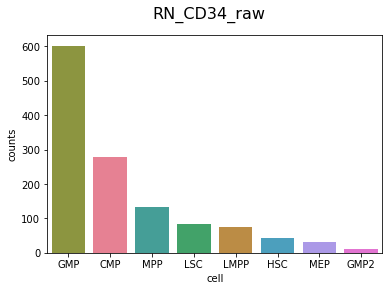

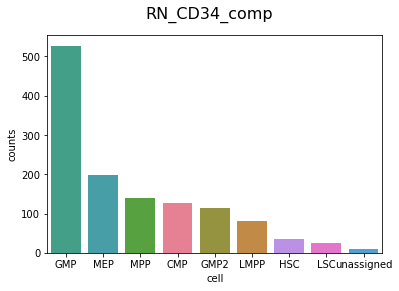

In [42]:
#Assign cell types and plot the distribution

CD34_alldata_ct = celltype_assign(CD34_alldata, gate_loc, 'RN_CD34_raw')
CD34_alldata_comp_ct = celltype_assign(CD34_alldata_comp, gate_loc_comp, 'RN_CD34_comp')

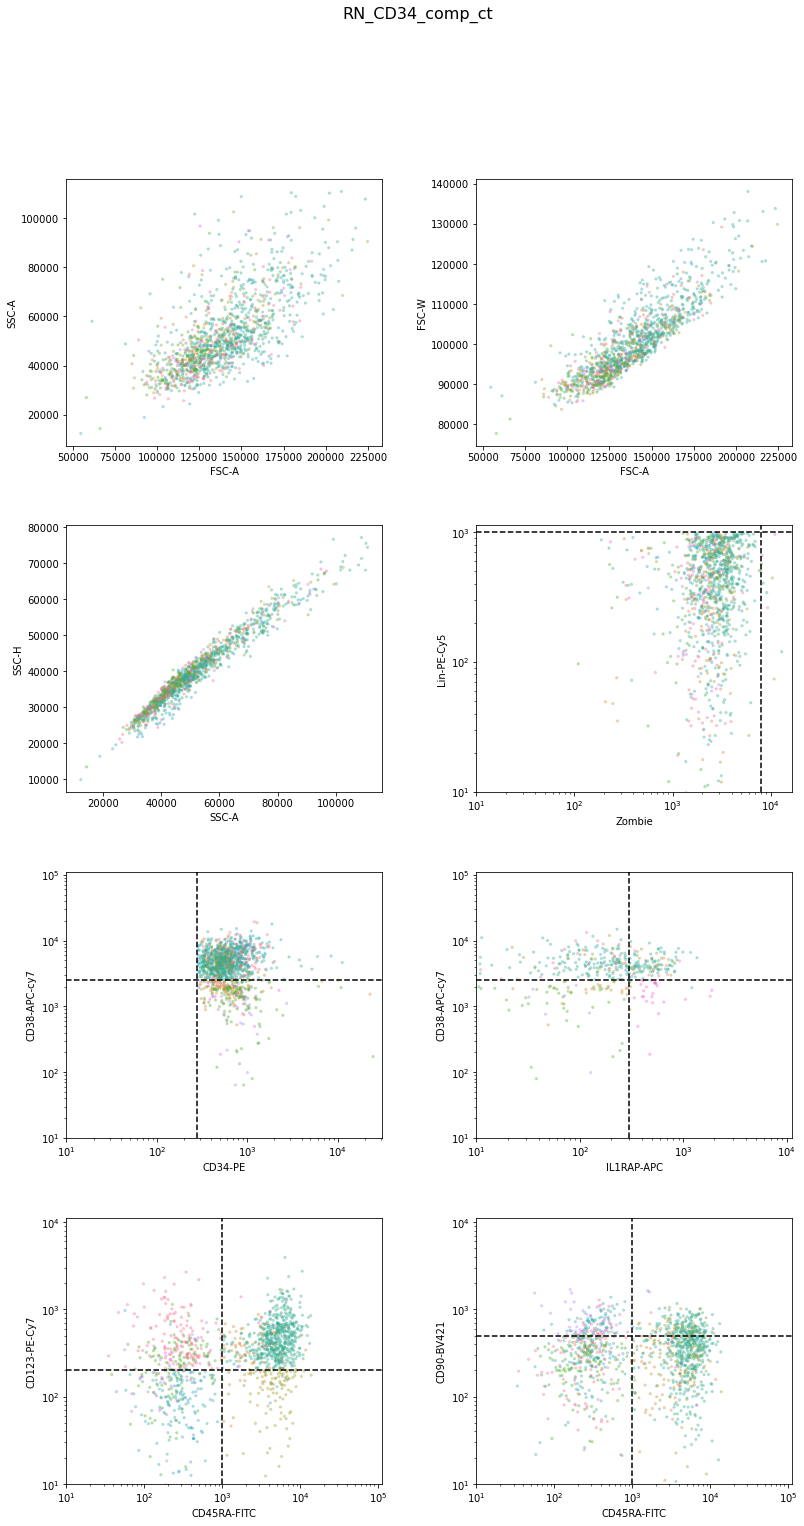

In [38]:
#Plot by cell type

#CD34flowplot_bycelltype(CD34_alldata_ct, gate_loc, 'RN_CD34_raw_ct')
CD34flowplot_bycelltype(CD34_alldata_comp_ct, gate_loc_comp, 'RN_CD34_comp_ct')

In [52]:
#Compare cell assignments - old schema, new schema , new  schema_comp. 
#Older schema had many unassigned cells
#New schema has GMP2 which is GMP-like cells that lack CD123 expression
#New schema also requires normal CD38neg cells to be IL1RAP negative (otherwise LSC was ?overwritten with other types)
old = pd.read_csv('../Data/RN_BM_index.tsv', sep = '\t',  index_col = 0)
new = pd.read_csv('../Data/RN_CD34_raw_index_ID.tsv', sep = '\t',  index_col = 0)
new_comp = pd.read_csv('../Data/RN_CD34_comp_index_ID.tsv', sep = '\t',  index_col = 0)
result = pd.merge(old, new, on = 'Plate_Well')
result = pd.merge(result, new_comp, on = 'Plate_Well')
result.columns = ['Plate_Well', 'older_gating', 'uncomp', 'comp']
result.loc[result['older_gating'] == 'GMP']

,Plate_Well,older_gating,uncomp,comp
2,not_seq_A4,GMP,GMP,GMP2
5,not_seq_A7,GMP,GMP,GMP
6,not_seq_A8,GMP,GMP,GMP
9,not_seq_A11,GMP,GMP,GMP2
12,not_seq_A14,GMP,GMP,GMP
...,...,...,...,...
1129,AS-198_O20,GMP,GMP,GMP
1133,AS-198_O24,GMP,GMP,GMP
1134,AS-198_P24,GMP,GMP,GMP
1137,AS-198_P21,GMP,GMP,GMP2
